As every year since 2015, I'm signed up to participate in the qualifications round of [Google Hashcode](https://hashcode.withgoogle.com), a programming competition for students and professionals from Europe, the Middle-East and Africa. While trying to prepare for the competition, I tackled the suggested training problem that aims at cutting pizza slices out of a large pizza. 

In this post, I'll try to outline a solution to the problem based on one of the input files, the `medium.in` input. Along the way, I plan to report on the following topics:

- visualizing your data
- formulating the problem as a greedy optimization task
- knowing your data structures 
- profiling your code
- using Pythran to optimize your code execution time


Let's get started.

# Visualizing your data 

The large pizza we will use as input consists of Tomatoes as well as Mushrooms, which is encode in a grid like the following: 

```
TTTTT
TMMMT
TTTTT
```

Let's load the data for our example grid:

In [1]:
import numpy as np

In [2]:
def read_input_pizza(filename):
    """Reads the input of a Pizza problem.

    returns:

    R: number of Rows of pizza grid
    C: number of Cols of pizza grid
    L: Lowest number of each ingredients per slice
    H: Highest number of cells per slice
    pizza: the pizza grid (1 == tomato, 0 == mushroom)
    """
    lines = open(filename).readlines()
    R, C, L, H = [int(val) for val in lines[0].split()]
    pizza = np.array([list(map(lambda item: 1 if item == 'T' else 0, row.strip())) for row in lines[1:]])
    return R, C, L, H, pizza

In [3]:
R, C, L, H, pizza = read_input_pizza('files/medium.in')

Let's also plot the pizza:

In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

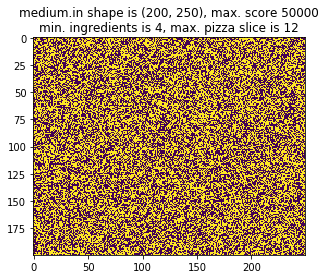

In [5]:
fig, ax = plt.subplots()
ax.imshow(pizza)
ax.set_title(f'medium.in shape is {pizza.shape}, max. score {pizza.size}\nmin. ingredients is {L}, max. pizza slice is {H}');

As you can read in the above plot, the pizza has a 200 by 250 shape, will need slices that have each at least 4 tomatoes and 4 mushrooms on it and a maximum size of 12 cells. Also, as far as I can tell from that plot, the pizza is made of evenly distributed ingredients.

Let's now try to come up with an algorithm.

# A greedy optimization approach 

While brainstorming  this problem with a friend, we came up with a greedy approach for solving the problem. It can be described by the following Python pseudo-code:

```python
slices = []

while True:
    # randomly choose an available location for the start of the slice
    location = get_random_available_location(pizza)

    # select a random shape and try to fit it at the selected location
    slice_shape = get_random_shape(shapes)
    if satisfy_constraints(location, slice_shape, pizza):
        slices.append(slice(location, slice_shape))
    
        # since we sliced the pizza, we need to update the available cells 
        update_pizza(pizza, this_slice)            
    
    # should we exit while loop?
    if no_more_possible_slices() or iteration_limit_reached():
        break
   
```

The way the problem is described above has two properties:

- it is greedy (if the slice fits, we put it there)
- it is an optimization problem (since we loop until there's nothing left to do)

I believe this is generally a good way to solve the problems that come up at Hashcode competitions, thinking about past editions...

# A first version 

With that being said, we can transform the pseudo-code into real code. Below is my first version.

Note that:

- the possible shapes are hard-coded
- we only try one of the possible shapes at the location and move on if it doesn't work

In [6]:
import tqdm
from random import randint

def get_random_available_location(slice_mask):
    """Returns a randomly selected empty location on the slice mask."""
    nonzero_elements = np.nonzero(1 - slice_mask)
    n = len(nonzero_elements[0])
    index = randint(0, n - 1)
    return nonzero_elements[0][index], nonzero_elements[1][index]

def satisfy_constraints(location, shape, slice_mask, pizza, L, H):
    """Validates whether the given location and slice shape can be applied to the pizza."""
    r, c = location
    dr, dc = shape
    if slice_mask[r:r+dr, c:c+dc].size == dr * dc:
        if np.all(slice_mask[r:r+dr, c:c+dc] == 0):
            if dr * dc <= H:
                tomatoes = np.sum(pizza[r:r+dr, c:c+dc])
                mushrooms = dr * dc - tomatoes
                if tomatoes >= L and mushrooms >= L:
                    return True
    return False

def cut_slice(location, shape, current_slices, slice_mask):
    """Adds a given slice defined by location and shape to existing slices and
    updates the slice mask."""
    r, c = location
    dr, dc = shape
    slice_mask[r:r + dr, c:c + dc] = 1
    current_slices.append((r, c, dr, dc))

def score(pizza_slices):
    """Computes score of given pizza_slices list."""
    s = 0
    for pizza_slice in pizza_slices:
        s += pizza_slice[2] * pizza_slice[3]
    return s

def write_output_pizza(filename, pizza_slices):
    """Writes an output file with the required format."""
    with open(filename, 'w') as f:
        f.write(f"{len(pizza_slices)}\n")
        for slice in pizza_slices:
            r, c, dr, dc = slice
            f.write(f"{r} {c} {r+dr-1} {c+dc-1}\n")

def greedy1(fname):
    """Greedy approach to the pizza slice problem.
    We try one random shape at one random point each turn."""
    R, C, L, H, pizza = read_input_pizza(fname)
    possible_shapes = [(4, 2), (2, 4), (3, 3), (5, 2), (2, 5), (11, 1), (1,11), (2, 6), (6, 2), (3, 4), (4, 3)]
    slice_mask = np.zeros_like(pizza) # stores the sliced cells as 1 for easy lookup
    pizza_slices = [] # stores the slices we made
    for _ in tqdm.tqdm(range(20000)):
        location = get_random_available_location(slice_mask)
        shape = possible_shapes[randint(0, len(possible_shapes) - 1)]
        if satisfy_constraints(location, shape, slice_mask, pizza, L, H):
            cut_slice(location, shape, pizza_slices, slice_mask)
    print('\n')
    print(f"score: {score(pizza_slices)}")
    write_output_pizza(fname.split('.')[0]+'.out', pizza_slices)

In [7]:
greedy1('files/medium.in')

100%|██████████| 20000/20000 [00:19<00:00, 1026.98it/s]



score: 28923


Let's take a look at the output from the algorithm.

In [8]:
fig, ax 

(<matplotlib.figure.Figure at 0x119ff26a0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x119ff2f28>)

In [9]:
def show_output(fname):
    """Reads an output file, assuming it's valid and plots the result."""
    input_fname = fname.split('.')[0] + '.in'
    R, C, L, H, pizza = read_input_pizza(input_fname)
    lines = open(fname).readlines()
    N = int(lines[0].strip())
    slice_mask = np.zeros_like(pizza)
    pizza_slices = []
    for i in range(1, N+1):
        r, c, dr, dc = [int(val) for val in lines[i].strip().split()]
        dr += 1 - r
        dc += 1 - c 
        slice_mask[r:r + dr, c:c + dc] = i
        pizza_slices.append([r, c, dr, dc])
    
    fig, axes = plt.subplots(figsize=(9, 4), ncols=2, sharex=True, sharey=True)
    axes[0].imshow(slice_mask)
    axes[0].set_title(f'coloring by slice number (1 to {slice_mask.max()})')

    axes[1].imshow((slice_mask > 0).astype(np.int))
    axes[1].set_title('coloring by empty (green) / occupied (yellow)')

    plt.suptitle(f'solution score: {score(pizza_slices)}')
    plt.tight_layout(rect=[0, 0, 1, .95])
    
    axes[1].axis((-.5, C-.5, R-.5, -.5))

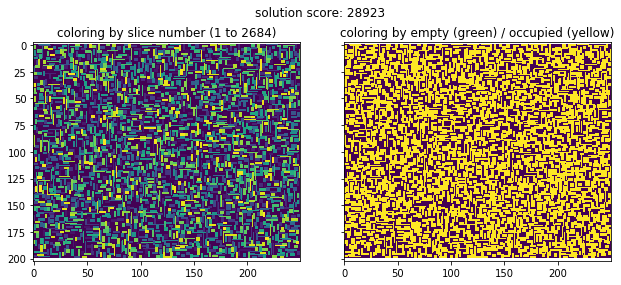

In [10]:
show_output('files/medium.out')

As we can see in the plot on the left, a random colored pattern emerges from our algorithm, since we try to slice at random patterns every time.

But how can we improve our existing solution? One possibility is to improve its performance. Although the algorithm runs in a couple of seconds for this grid size, it will be slow on the largest grid. So let's profile it to see what takes the most time.

In [11]:
%load_ext line_profiler

In [12]:
r = %lprun -r -f greedy1 greedy1('files/medium.in')
r.print_stats()

100%|██████████| 20000/20000 [00:14<00:00, 1354.32it/s]




score: 28839
Timer unit: 1e-06 s

Total time: 14.6957 s
File: <ipython-input-6-0cd214f13b94>
Function: greedy1 at line 47

Line #      Hits         Time  Per Hit   % Time  Line Contents
    47                                           def greedy1(fname):
    48                                               """Greedy approach to the pizza slice problem.
    49                                               We try one random shape at one random point each turn."""
    50         1      26742.0  26742.0      0.2      R, C, L, H, pizza = read_input_pizza(fname)
    51         1          5.0      5.0      0.0      possible_shapes = [(4, 2), (2, 4), (3, 3), (5, 2), (2, 5), (11, 1), (1,11), (2, 6), (6, 2), (3, 4), (4, 3)]
    52         1        197.0    197.0      0.0      slice_mask = np.zeros_like(pizza) # stores the sliced cells as 1 for easy lookup
    53         1          2.0      2.0      0.0      pizza_slices = [] # stores the slices we made
    54     20001     289406.0     14.5   

I was very surprised at this point: the function that takes the most time is the one selecting one random empty locaiton on the grid! Why is that? Well, it turns out at each iteration we are going over 200x250 = 50000 points to check whether they are zero or one. This takes a lot of time. We could do better with different data structures:

- first, a set of available locations for fast lookup
- second, a list of available locations for fast random indexing

Also:

- let's programmatically generate all possible shapes for the given grid as a function of its minimum number of ingredients and maximum slice size
- and let's loop at a given location over all of these possible slice shapes before choosing the best one

With this in mind, here's an upgraded version of the previous function.

# An upgraded version

In [13]:
import sympy
from random import shuffle

def generate_all_shapes(L, H):
    """Generates all possible tuples that satisfy the problem's shape constraints."""
    possible_shapes = []
    for size in range(2*L, H+1):
        factors = sympy.factorint(size)
        if len(factors) == 1:
            prime = list(factors.keys())[0]
            max_exp = list(factors.values())[0]
            for exp in range(0, max_exp+1):
                factor1 = prime ** exp
                factor2 = prime ** (max_exp - exp)
                possible_shapes.append((factor1, factor2))
        elif len(factors) == 2:
            prime1, prime2 = list(factors.keys())
            max_exp1, max_exp2 = list(factors.values())
            for exp1 in range(0, max_exp1+1):
                for exp2 in range(0, max_exp2+1):
                    factor1 = prime1 ** (max_exp1 - exp1) * prime2 ** (max_exp2 - exp2)
                    factor2 = prime1 ** (exp1) * prime2 ** (exp2)
                    possible_shapes.append((factor1, factor2))
        else:
            raise NotImplementedError
    return possible_shapes

def get_random_available_location_set2(random_locations, empty_cells):
    """Selects a random location that is still in empty_cells."""
    while len(random_locations) > 0:
        candidate = random_locations.pop()
        if candidate in empty_cells:
            return candidate
    else:
        return None

def update_empty_cells(location, shape, empty_cells):
    """Updates the empty cell dictionary."""
    r, c = location
    dr, dc = shape
    for rr in range(r, r+dr):
        for cc in range(c, c+dc):
            empty_cells.discard((rr, cc))
    
def greedy5(fname, iters=30000):
    """Greedy approach to pizza slicing.
    Fifth iteration: randomize the locations in which we try to add stuff."""
    R, C, L, H, pizza = read_input_pizza(fname)
    possible_shapes = generate_all_shapes(L, H)
    slice_mask = np.zeros_like(pizza)  # stores the sliced cells as 1 for easy lookup
    pizza_slices = []  # stores the slices we made
    empty_cells = set(tuple(args) for args in np.transpose(np.nonzero(1-slice_mask)).tolist())
    random_locations = list(x for x in empty_cells)
    shuffle(random_locations)
    current_score = 0
    for _ in tqdm.tqdm(range(iters)):
        location = get_random_available_location_set2(random_locations, empty_cells)
        if location is None:
            break
        selected_shapes = []
        for shape in possible_shapes:
            if satisfy_constraints(location, shape, slice_mask, pizza, L, H):
                selected_shapes.append(shape)
        if len(selected_shapes) > 0:
            current_score = score(pizza_slices)
            shape = max(selected_shapes, key=lambda shp: current_score + shp[0]*shp[1])
            cut_slice(location, shape, pizza_slices, slice_mask)
            update_empty_cells(location, shape, empty_cells)
    print('\n')
    print(f"score: {score(pizza_slices)}")
    write_output_pizza(fname.split('.')[0] + '.out', pizza_slices)

In [14]:
greedy5('files/medium.in')

 51%|█████     | 15193/30000 [00:03<00:03, 4484.51it/s]



score: 39850


Our score is greatly improved by the new algorithm, especially since we now try every possible solution. What does the pizza tiling now look like?

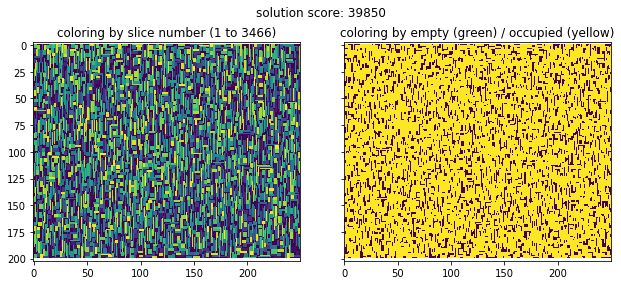

In [15]:
show_output('files/medium.out')

This looks a lot more compact although it's not completely yellow. Also, it runs much faster now. How much faster?

In [16]:
r = %lprun -r -f greedy5 greedy5('files/medium.in')
r.print_stats()

 53%|█████▎    | 15817/30000 [00:08<00:07, 1814.87it/s]



score: 39889
Timer unit: 1e-06 s

Total time: 7.95831 s
File: <ipython-input-13-6596edaa9978>
Function: greedy5 at line 45

Line #      Hits         Time  Per Hit   % Time  Line Contents
    45                                           def greedy5(fname, iters=30000):
    46                                               """Greedy approach to pizza slicing.
    47                                               Fifth iteration: randomize the locations in which we try to add stuff."""
    48         1      48290.0  48290.0      0.6      R, C, L, H, pizza = read_input_pizza(fname)
    49         1        294.0    294.0      0.0      possible_shapes = generate_all_shapes(L, H)
    50         1         80.0     80.0      0.0      slice_mask = np.zeros_like(pizza)  # stores the sliced cells as 1 for easy lookup
    51         1          3.0      3.0      0.0      pizza_slices = []  # stores the slices we made
    52         1     101737.0 101737.0      1.3      empty_cells = set(tuple(args) 

# Optimization using Pythran 

As you can see in the above timing, the two most intensive functions are the `score` function and the `satisfy_constraints` function.

It turns out that with a little Pythran-fu, we can optimize these to run faster. [Pythran](http://serge-sans-paille.github.io/pythran-stories/pythran-tutorial.html) is a cool C++ compiler that knows how to handle Python and a lot of Numpy array stuff. By annotating the types we want, it can compile an optimized module from our functions.

Let's demonstrate this on the two above functions.

In [17]:
pizza_slices = [(305, 223, 7, 2), (172, 21, 14, 1), (538, 255, 14, 1), (861, 247, 7, 2), (634, 248, 2, 7), (518, 828, 14, 1)]

In [18]:
%load_ext pythran.magic

In [19]:
%%pythran
#pythran export score_pythran((int, int, int, int) list)
def score_pythran(pizza_slices):
    """Computes score of given pizza_slices list."""
    s = 0
    for pizza_slice in pizza_slices:
        s += pizza_slice[2] * pizza_slice[3]
    return s

In [20]:
%timeit score(pizza_slices)

723 ns ± 4.13 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [21]:
%timeit score_pythran(pizza_slices)

634 ns ± 11.8 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


We can do the same for the constraints call:

In [22]:
%%pythran
#pythran export satisfy_constraints_pythran((int, int), (int, int), int[][], int[][], int, int)
def satisfy_constraints_pythran(location, shape, slice_mask, pizza, L, H):
    """Validates whether the given location and slice shape can be applied to the pizza."""
    r, c = location
    dr, dc = shape
    if slice_mask[r:r+dr, c:c+dc].size == dr * dc:
        if (slice_mask[r:r+dr, c:c+dc] == 0).all():
            if dr * dc <= H:
                tomatoes = pizza[r:r+dr, c:c+dc].sum()
                mushrooms = dr * dc - tomatoes
                if tomatoes >= L and mushrooms >= L:
                    return True
    return False

In [23]:
%timeit satisfy_constraints((3, 4), (4, 1), np.ones((R, C), dtype=np.int), np.ones((R, C), dtype=np.int), L, H)

63.7 µs ± 295 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [24]:
%timeit satisfy_constraints_pythran((3, 4), (4, 1), np.ones((R, C), dtype=np.int), np.ones((R, C), dtype=np.int), L, H)

54.2 µs ± 248 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Equipped with this, we can now rewrite our algorithm like so:

In [25]:
def greedy5_pythran(fname, iters=30000, disable_progress_bar=False):
    """Greedy approach to pizza slicing.
    Fifth iteration: randomize the locations in which we try to add stuff."""
    R, C, L, H, pizza = read_input_pizza(fname)
    possible_shapes = generate_all_shapes(L, H)
    slice_mask = np.zeros_like(pizza)  # stores the sliced cells as 1 for easy lookup
    pizza_slices = []  # stores the slices we made
    empty_cells = set(tuple(args) for args in np.transpose(np.nonzero(1-slice_mask)).tolist())
    random_locations = list(x for x in empty_cells)
    shuffle(random_locations)
    current_score = 0
    for _ in tqdm.tqdm(range(iters), disable=disable_progress_bar):
        location = get_random_available_location_set2(random_locations, empty_cells)
        if location is None:
            break
        selected_shapes = []
        for shape in possible_shapes:
            if satisfy_constraints_pythran(location, shape, slice_mask, pizza, L, H):
                selected_shapes.append(shape)
        if len(selected_shapes) > 0:
            current_score = score_pythran(pizza_slices)
            shape = max(selected_shapes, key=lambda shp: current_score + shp[0]*shp[1])
            cut_slice(location, shape, pizza_slices, slice_mask)
            update_empty_cells(location, shape, empty_cells)
    return score(pizza_slices)

In [26]:
greedy5_pythran('files/medium.in')

 39%|███▉      | 11779/30000 [00:00<00:00, 29440.63it/s]


39770

This now runs almost instantly. Let's check the profiling again:

In [27]:
r = %lprun -r -f greedy5_pythran greedy5_pythran('files/medium.in', disable_progress_bar=True)
r.print_stats()

Timer unit: 1e-06 s

Total time: 1.71979 s
File: <ipython-input-25-3e117007c84a>
Function: greedy5_pythran at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def greedy5_pythran(fname, iters=30000, disable_progress_bar=False):
     2                                               """Greedy approach to pizza slicing.
     3                                               Fifth iteration: randomize the locations in which we try to add stuff."""
     4         1      30197.0  30197.0      1.8      R, C, L, H, pizza = read_input_pizza(fname)
     5         1        469.0    469.0      0.0      possible_shapes = generate_all_shapes(L, H)
     6         1        758.0    758.0      0.0      slice_mask = np.zeros_like(pizza)  # stores the sliced cells as 1 for easy lookup
     7         1          2.0      2.0      0.0      pizza_slices = []  # stores the slices we made
     8         1     120025.0 120025.0      7.0      em

Now that we have such a fast function, we can run further improve our algorithm.

# Studying different ways of iterating through the pizza 

The next idea here is to vary the way we sort the pizza locations before trying to slice the pizza. Instead of doing a random search as we did so far, let's explore more straightforward sortings: by row or column, decreasing as well as increasing.

In [28]:
def greedy5_pythran(fname, iters=30000, sorting_func=lambda item: item[0], disable_progress_bar=False):
    """Greedy approach to pizza slicing.
    Fifth iteration: randomize the locations in which we try to add stuff."""
    R, C, L, H, pizza = read_input_pizza(fname)
    possible_shapes = generate_all_shapes(L, H)
    slice_mask = np.zeros_like(pizza)  # stores the sliced cells as 1 for easy lookup
    pizza_slices = []  # stores the slices we made
    empty_cells = set(tuple(args) for args in np.transpose(np.nonzero(1-slice_mask)).tolist())
    random_locations = list(x for x in empty_cells)
    random_locations = sorted(random_locations, key=sorting_func)
    current_score = 0
    for _ in tqdm.tqdm(range(iters), disable=disable_progress_bar):
        location = get_random_available_location_set2(random_locations, empty_cells)
        if location is None:
            break
        selected_shapes = []
        for shape in possible_shapes:
            if satisfy_constraints_pythran(location, shape, slice_mask, pizza, L, H):
                selected_shapes.append(shape)
        if len(selected_shapes) > 0:
            current_score = score_pythran(pizza_slices)
            shape = max(selected_shapes, key=lambda shp: current_score + shp[0]*shp[1])
            cut_slice(location, shape, pizza_slices, slice_mask)
            update_empty_cells(location, shape, empty_cells)
    write_output_pizza(fname.split('.')[0] + '.out', pizza_slices)
    return score(pizza_slices)

 49%|████▊     | 14595/30000 [00:00<00:00, 36472.30it/s]


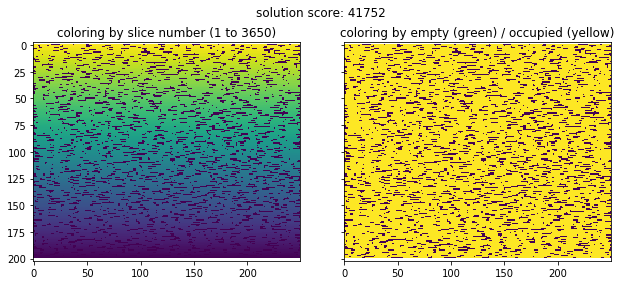

In [29]:
greedy5_pythran('files/medium.in', sorting_func=lambda item: item[0])
show_output('files/medium.out')

 19%|█▉        | 5736/30000 [00:00<00:01, 14335.55it/s]


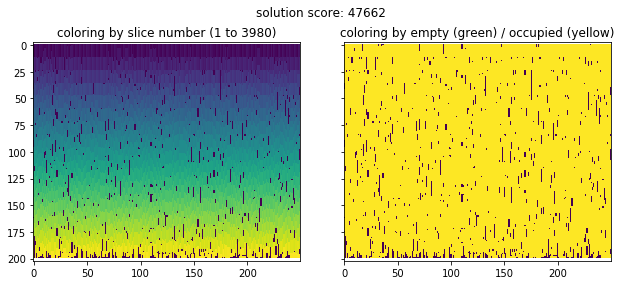

In [30]:
greedy5_pythran('files/medium.in', sorting_func=lambda item: -item[0])
show_output('files/medium.out')

 49%|████▉     | 14641/30000 [00:00<00:00, 36587.97it/s]


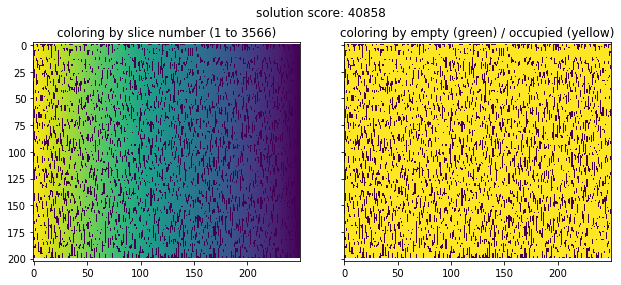

In [31]:
greedy5_pythran('files/medium.in', sorting_func=lambda item: item[1])
show_output('files/medium.out')

 16%|█▌        | 4826/30000 [00:00<00:01, 16077.76it/s]


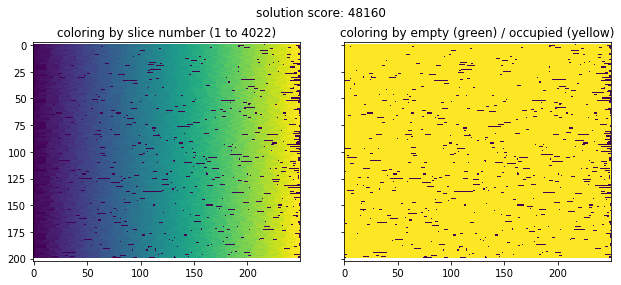

In [32]:
greedy5_pythran('files/medium.in', sorting_func=lambda item: -item[1])
show_output('files/medium.out')

This is really interesting: the best scores are obtained when cutting the pizza from left to right as well as from top to bottom. Does it also work with oblique directions?

 18%|█▊        | 5326/30000 [00:00<00:01, 13304.85it/s]


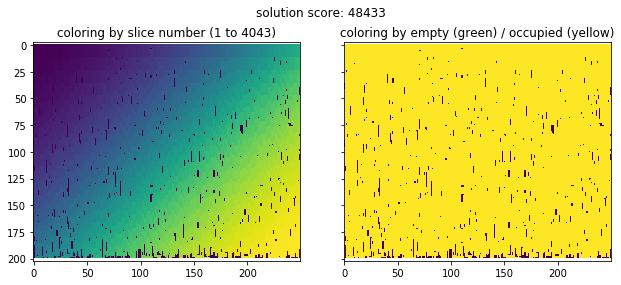

In [33]:
greedy5_pythran('files/medium.in', sorting_func=lambda item: -item[0] -item[1])
show_output('files/medium.out')

This is our best score so far! Can we get even better? We should, since we see that the bottom part of the pizza is not well filled, with some border artifacts appearing.

At this point, an idea that often comes up for this sort of optimization problems is to try to improve an existing sliced pizza with some local changes, an idea known as "hill climbing" (see this Norvig Pytude about [gesture typing](https://github.com/norvig/pytudes/blob/master/ipynb/Gesture%20Typing.ipynb) for a good example).

# Improving an existing solution 

Let's say we have an existing solution and we want to improve it. One possible way is to remove a set number of slices from the pizza, for example the 3 closest parts to a hole in the pizza, and try to fill it again while trying out every possible combination.

In [34]:
from random import choice

def remove_slice(this_slice, empty_cells, pizza_slices, slice_mask):
    """Removes a slice that was sliced from the pizza."""
    pizza_slices.remove(this_slice)
    r, c, dr, dc = this_slice
    for rr in range(r, r+dr):
        for cc in range(c, c+dc):
            empty_cells.add((rr, cc))
            
    slice_mask[r:r + dr, c:c + dc] = 0

def improve_pizza(fname, slices_to_remove=3, iters=1000):
    """Reads an output of pizza slices and tries to improve it by removing slices."""
    input_fname = fname.split('.')[0] + '.in'
    R, C, L, H, pizza = read_input_pizza(input_fname)
    possible_shapes = generate_all_shapes(L, H)
    lines = open(fname).readlines()
    N = int(lines[0].strip())
    slice_mask = np.zeros_like(pizza)
    pizza_slices = []
    for i in range(1, N + 1):
        r, c, dr, dc = [int(val) for val in lines[i].strip().split()]
        dr += 1 - r
        dc += 1 - c
        slice_mask[r:r + dr, c:c + dc] = i
        pizza_slices.append((r, c, dr, dc))
    # find empty pizza cells and make a set out of it
    empty_cells_list = np.transpose(np.nonzero(slice_mask == 0)).tolist()
    empty_cells = set(tuple(args) for args in empty_cells_list)
    print(f"starting score {score_pythran(pizza_slices)}")
    for _ in tqdm.tqdm(range(iters), disable=True):
        # copy params
        empty_cells_original = empty_cells.copy()
        pizza_slices_original = pizza_slices.copy()
        slice_mask_original = slice_mask.copy()

        # select a random location on the pizza grid from one of the already vacant spots
        removal_location = choice(empty_cells_list)
        # remove existing slices closest to the grid
        sorted_slices = sorted(pizza_slices, key=lambda item: abs(item[0] + item[2] / 2 - removal_location[0]) + \
                                                              abs(item[1] + item[3] / 2 - removal_location[1]))
        for this_slice in sorted_slices[:slices_to_remove]:
            remove_slice(this_slice, empty_cells, pizza_slices, slice_mask)
        # try to place new slices by trying out all possible solutions
        candidates = list(empty_cells_original)
        shuffle(candidates)
        for location in candidates:
            selected_shapes = []
            for shape in possible_shapes:
                if satisfy_constraints_pythran(location, shape, slice_mask, pizza, L, H):
                    selected_shapes.append(shape)
            if len(selected_shapes) > 0:
                current_score = score_pythran(pizza_slices)
                shape = max(selected_shapes, key=lambda shp: current_score + shp[0] * shp[1])
                cut_slice(location, shape, pizza_slices, slice_mask)
                update_empty_cells(location, shape, empty_cells)

        if score_pythran(pizza_slices) <= score_pythran(pizza_slices_original):
            empty_cells = empty_cells_original
            pizza_slices = pizza_slices_original
            slice_mask = slice_mask_original
        else:
            print(f"improved score: {score_pythran(pizza_slices)}")
    write_output_pizza(fname.split('.')[0] + '.out', pizza_slices)

In [37]:
improve_pizza('files/medium.out', slices_to_remove=3, iters=1000)

starting score 48433
improved score: 48434
improved score: 48442
improved score: 48446
improved score: 48449
improved score: 48452
improved score: 48458
improved score: 48464
improved score: 48468
improved score: 48470
improved score: 48471
improved score: 48473
improved score: 48483
improved score: 48484
improved score: 48494
improved score: 48496


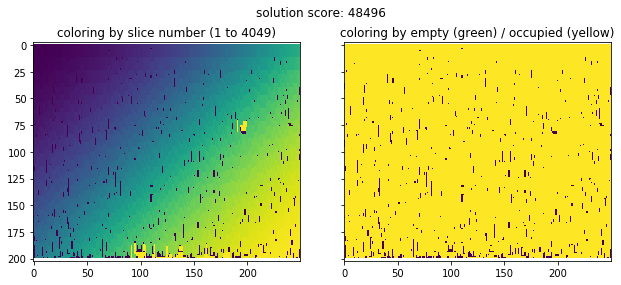

In [38]:
show_output('files/medium.out')

We can observe the result of our hill-climbing algorithm here: it added a few optimisations to some of the pizza slices at the bottom of the field, shown in the left plot as patches of yellow color (slices added last). If we let it run for a long time, maybe it would add some more of these patches.

# Conclusions

In this blog post, we went from an idea to the implementation of a fast greedy solution to the training problem of the 2018 Google Hashcode. We then improved it using an iterative hill-climbing algorithm. I think this nicely shows how all the moving parts of a Hashcode problem fit together.

To conclude, here's a high level summary of the tools that I found useful while tackling the pizza cutting problem:

- know your data structures and their speeds: when I realized that I needed [sets](https://docs.python.org/3.6/library/stdtypes.html?highlight=set#set) (for fast membership testing) and lists (for fast lookup of index $n$) I got a 10x speedup
- use a debugger for development: during the writing of the above code (something that is not shown in this Jupyter notebook), the Pycharm debugger proved invaluable
- profile your functions using line_profiler and troubleshoot your hotspots
- use Jupyter Notebook for interactive exploration and plotting 
- use pythran or numba if you need to make things faster
- use tqdm to display progress bars! this gives you great feedback about how your algorithm is doing

*This post was entirely written using the IPython notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20180207_PreparingHashcode2018.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20180207_PreparingHashcode2018.ipynb).*